# Image Captioning using Deep Learning to Ensure Security
## Introduction
This model aims to describe the content of an image by using CNNs and RNNs to build an Image Caption Generator. The model will be implemented using Tensorflow and Keras. The dataset used is Flickr 8K, consisting of 8,000 images each one paired with five different captions to provide clear descriptions. 


## References
[1] Image captioning with visual attention: https://www.tensorflow.org/tutorials/text/image_captioning

[2] RNNs in Computer Vision — Image captioning: https://thinkautonomous.medium.com/rnns-in-computer-vision-image-captioning-597d5e1321d1

[3] Image Captioning Project from Udacity Computer Vision Nanodegree: https://github.com/raunak222/Image-Captioning

[4] Show and Tell: A Neural Image Caption Generator: https://arxiv.org/pdf/1411.4555.pdf

[5] Flickr 8k Dataset: https://www.kaggle.com/adityajn105/flickr8k

## Copyrighted By
All Models and In-House Research belongs solely to WorqHat (Winlysis Private Limited) and the Users provided under the Accepted Terms and Conditions. 

## Dependencies

In [36]:
import re # regular expressions
import random # for shuffling the data before splitting into train and test sets

import numpy as np # linear algebra 
import tensorflow as tf # 1.0.0 version of tensorflow is used here 
import matplotlib.pyplot as plt # for plotting images and captions in the notebook itself 

from tensorflow import keras # tf.keras is an alias for keras in TensorFlow 2.0 and above 
from time import time # for timing the training process 

from tqdm import tqdm # progress bar library for loops 
from sklearn.model_selection import train_test_split # Dividing train test data set 
from nltk.translate.bleu_score import corpus_bleu # BLEU Score for evaluation of model performance on test set

## Dataset
Load dataset from local path or google drive

In [37]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [38]:
# Change this path to the dataset downloaded from Flickr8 [5]
dataset_path = "../archive"
dataset_images_path = dataset_path + "/Images/" 

Images configuration

In [39]:
img_height = 180  # Height of the image
img_width = 180  # Width of the image
validation_split = 0.2 # 20% of the data will be used for validation

### Encoder Model

In order to extract the features from the images, a pretrained CNN model, named Inception V3 was used. In the figure below, there is the representation of the architecture of the used network.

![Inception Architecture](https://paperswithcode.com/media/methods/inceptionv3onc--oview_vjAbOfw.png)

In [40]:
# Remove the last layer of the Inception V3 model
def get_encoder(): # returns the encoder model
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet') # include_top=False means that the last layer of the model is not included in the model and weights='imagenet' means that the model is trained on the ImageNet dataset
    new_input = image_model.input # input layer of the model 
    hidden_layer = image_model.layers[-1].output # last layer of the model 

    image_features_extract_model = tf.keras.Model(new_input, hidden_layer) # creating a new model with the input and output layers as the input and output layers of the Inception V3 model respectively
    return image_features_extract_model # returns the encoder model 

### Read captions
Create dictionary with picture filename as the key and an array of captions as the value

The model architectures consists of a CNN which extracts the features and encodes the input image and a Recurrent Neural Network (RNN) based on Long Short Term Memory (LSTM) layers. The most significant difference with other models is that the image embedding is provided as the first input to the RNN network and only once.
![Model Architecture](https://github.com/raunak222/Image-Captioning/raw/master/Image/decoder.png)


In [41]:
# Preprocess the caption, splitting the string and adding <start> and <end> tokens
def get_preprocessed_caption(caption): # returns the preprocessed caption 
    caption = re.sub(r'\s+', ' ', caption) # replace all the white spaces with a single white space 
    caption = caption.strip() # remove the white spaces from the start and end of the string
    caption = "<start> " + caption + " <end>" # add the <start> and <end> tokens to the caption
    print (caption)
    return caption # returns the preprocessed caption

In [42]:
images_captions_dict = {} # dictionary to store the image name and the corresponding caption

with open(dataset_path + "/captions.txt", "r") as dataset_info: # open the captions.txt file in read mode
    next(dataset_info) # Omit header: image, caption 

    # Using a subset of 4,000 entries out of 8,000
    for info_raw in list(dataset_info)[:8000]: # iterate over the captions.txt file
        info = info_raw.split(",") # split the string at the comma and store the result in a list 
        image_filename = info[0] # image name
        caption = get_preprocessed_caption(info[1]) # preprocessed caption

        if image_filename not in images_captions_dict.keys(): # if the image name is not in the dictionary 
            images_captions_dict[image_filename] = [caption] # add the image name and the corresponding caption to the dictionary
        else:
            images_captions_dict[image_filename].append(caption) # if the image name is already in the dictionary, append the caption to the list of captions corresponding to the image name

<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>
<start> A girl going into a wooden building . <end>
<start> A little girl climbing into a wooden playhouse . <end>
<start> A little girl climbing the stairs to her playhouse . <end>
<start> A little girl in a pink dress going into a wooden cabin . <end>
<start> A black dog and a spotted dog are fighting <end>
<start> A black dog and a tri-colored dog playing with each other on the road . <end>
<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>
<start> Two dogs of different breeds looking at each other on the road . <end>
<start> Two dogs on pavement moving toward each other . <end>
<start> A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . <end>
<start> A little girl is sitting in front of a large painted rainbow . <end>
<start> A small girl in the grass plays with fingerpaints in front of a white canvas with 

### Read images
Create dictionary with image filename as key and the image feature extracted using the pretrained model as the value.

In [43]:
def load_image(image_path): # returns the image
    img = tf.io.read_file(dataset_images_path + image_path) # read the image from the path
    img = tf.image.decode_jpeg(img, channels=3) # decode the image and change the channels to 3 for RGB images
    img = tf.image.resize(img, (img_height, img_width)) # resize the image to the specified height and width
    img = tf.keras.applications.inception_v3.preprocess_input(img) # preprocessing needed for pre-trained model
    return img, image_path # returns the image and the image name

In [44]:
image_captions_dict_keys = list(images_captions_dict.keys()) # list of image names 
image_dataset = tf.data.Dataset.from_tensor_slices(image_captions_dict_keys) # create a dataset from the list of image names
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64) # map the load_image function to the dataset and batch the dataset

In [45]:
images_dict = {} # dictionary to store the image name and the corresponding image
encoder = get_encoder() # get the encoder model
for img_tensor, path_tensor in tqdm(image_dataset): # iterate over the dataset and the progress bar will be displayed
    batch_features_tensor = encoder(img_tensor) # get the features of the image 
    
    # Loop over batch to save each element in images_dict
    for batch_features, path in zip(batch_features_tensor, path_tensor): # iterate over the features and the image name
        decoded_path = path.numpy().decode("utf-8") # decode the image name
        images_dict[decoded_path] = batch_features.numpy() # add the image name and the corresponding image to the dictionary

100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


Image size after extracting features from the pre-trained model

In [46]:
list(images_dict.items())[0][1].shape # shape of the image features 

(4, 4, 2048)

Display image from original dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


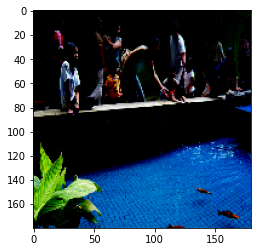

In [47]:
plt.imshow(load_image('12830823_87d2654e31.jpg')[0].numpy()) # display the image 


### Get images and labels from filenames

In [48]:
def get_images_labels(image_filenames): # returns the image features and the corresponding captions
    images = [] # list to store the image features in the form of a numpy array
    labels = [] # list to store the captions in the form of a numpy array
    
    for image_filename in image_filenames: # iterate over the image names 
        image = images_dict[image_filename] # get the image features corresponding to the image name
        captions = images_captions_dict[image_filename] # get the captions corresponding to the image name

        # Add one instance per caption
        for caption in captions: # iterate over the captions
            images.append(image) # append the image features to the list
            labels.append(caption) # append the caption to the list
            
    return images, labels # returns the image features and the corresponding captions

### Generate train and test set
This approach divides image_filenames, to avoid same image with different caption in train and test dataset. Also the resulting train test is not shuffled because a tensorflow native method will be used for that aim.

In [49]:
image_filenames = list(images_captions_dict.keys()) # list of image names
image_filenames_train, image_filenames_test = train_test_split(image_filenames, test_size=validation_split, random_state=1) # split the image names into training and testing sets based on the validation split and a random state of 1 is used for reproducibility of the results

X_train, y_train_raw = get_images_labels(image_filenames_train) # get the image features and the corresponding captions for the training set
X_test, y_test_raw = get_images_labels(image_filenames_test) # get the image features and the corresponding captions for the testing set

In [50]:
# Per image 5 captions and 0.2 test split
len(X_train), len(y_train_raw), len(X_test), len(y_test_raw) # length of the training and testing sets in the form of (image features, captions)

(6400, 6400, 1600, 1600)

### Tokenize train labels
Generate a vocabulary and transform the train captions to a vector with their indices in the vocabulary [1].

In [51]:
top_k = 5000 # Take maximum of words out of 7600
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ') # create a tokenizer object with the top_k words and the <unk> token and filters to remove the punctuations

# Generate vocabulary from train captions
tokenizer.fit_on_texts(y_train_raw) # fit the tokenizer on the training captions

# Introduce padding to make the captions of the same size for the LSTM model
tokenizer.word_index['<pad>'] = 0 # add the <pad> token to the word index dictionary
tokenizer.index_word[0] = '<pad>' # add the <pad> token to the index word dictionary 

# Create the tokenized vectors
y_train = tokenizer.texts_to_sequences(y_train_raw) # convert the training captions to sequences of integers

# Add padding to each vector to the max_length of the captions (automatically done)
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding='post') # pad the sequences of integers to the max_length of the captions

Calculate max caption length which would be the number of hidden layers in the LSTM.

In [52]:
max_caption_length = max(len(t) for t in y_train) # get the max_length of the captions 
print(max_caption_length) # print the max_length of the captions

35


Example tokenization

In [53]:
[tokenizer.index_word[i] for i in y_train[1]] # print the caption corresponding to the index 2 in the training set

['<start>',
 'two',
 'girls',
 'are',
 'walking',
 'along',
 'the',
 'street',
 'and',
 'talking',
 '<end>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

### Generate Tensorflow dataset
Generate dataset using buffer and batch size that would be used during training. 

In [54]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # create a dataset from the training set in the form of (image features, captions)

In [55]:
BUFFER_SIZE = len(X_train) # buffer size for shuffling the dataset 
BATCH_SIZE = 64 # batch size for the dataset 
NUM_STEPS = BUFFER_SIZE // BATCH_SIZE # number of steps for the dataset

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # shuffle the dataset and batch the dataset 

# Using prefetching: https://www.tensorflow.org/guide/data_performance#prefetching
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) # prefetch the dataset 

## Models Definition

### CNN Encoder

In [56]:
class CNN_Encoder(tf.keras.Model): # CNN encoder class
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim): # initialize the class
        super(CNN_Encoder, self).__init__() # initialize the parent class
        # shape after fc == (batch_size, 64, embedding_dim)
        self.flat = tf.keras.layers.Flatten() # flatten the image features
        self.fc = tf.keras.layers.Dense(embedding_dim) #, activation='relu') # fully connected layer with the embedding dimension and the ReLU activation function 

    def call(self, x): # call the class 
        x = self.flat(x) # flatten the image features
        x = self.fc(x) # pass the flattened image features through the fully connected layer 
        return x # return the flattened image features

### RNN Decoder

In [57]:
class RNN_Decoder(tf.keras.Model): # RNN decoder class
    def __init__(self, embedding_dim, units, vocab_size): # initialize the class
        super(RNN_Decoder, self).__init__() # initialize the parent class
        self.units = units # number of units in the LSTM layer

        # input_dim = size of the vocabulary
        # Define the embedding layer to transform the input caption sequence
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # embedding layer with the vocabulary size and the embedding dimension

        # Define the Long Short Term Memory layer to predict the next words in the sequence 
        self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True) # LSTM layer with the number of units, return sequences and return state set to True
            
        # Define a dense layer to transform the LSTM output into prediction of the best word
        self.fc = tf.keras.layers.Dense(vocab_size) #, activation='softmax') # fully connected layer with the vocabulary size and the softmax activation function

    # A function that transforms the input embeddings and passes them to the LSTM layer 
    def call(self, captions, features, omit_features = False, initial_state = None, verbose = False): # call the class
        if verbose: # if verbose is set to True
            print("Before embedding") # print the message
            print(captions.shape) # print the shape of the captions

        embed = self.embedding(captions) #(batch_size, 1, embedding_dim) # pass the captions through the embedding layer

        if verbose: # if verbose is set to True
            print("Embed") # print the message
            print(embed.shape) # print the shape of the captions

        features = tf.expand_dims(features, 1) # expand the dimensions of the image features
        
        if verbose: # if verbose is set to True
            print("Features") # print the message
            print(features.shape) # print the shape of the image features
        
        # Concatenating the image and caption embeddings before providing them to LSTM
        # shape == (batch_size, 1, embedding_dim + hidden_size)
        lstm_input = tf.concat([features, embed], axis=-2) if (omit_features == False) else embed # concatenate the image features and the captions embeddings
        
        if verbose: # if verbose is set to True
            print("LSTM input") # print the message
            print(lstm_input.shape) # print the shape of the LSTM input

        # Passing the concatenated vector to the LSTM
        output, memory_state, carry_state = self.lstm(lstm_input, initial_state=initial_state) # pass the concatenated vector to the LSTM layer

        if verbose: # if verbose is set to True
            print("LSTM output") # print the message
            print(output.shape) # print the shape of the LSTM output

        # Transform LSTM output units to vocab_size
        output = self.fc(output) # pass the LSTM output to the fully connected layer

        return output, memory_state, carry_state # return the output, memory state and carry state

    def reset_state(self, batch_size): # reset the state of the LSTM layer
        return tf.zeros((batch_size, self.units)) # return a tensor of zeros with the batch size and the number of units

## Train Stage

In [58]:
units = embedding_dim = 512 # As in the paper
vocab_size = min(top_k + 1, len(tokenizer.word_index.keys())) # vocabulary size

# Initialize encoder and decoder
encoder = CNN_Encoder(embedding_dim) # initialize the encoder
decoder = RNN_Decoder(embedding_dim, units, vocab_size) # initialize the decoder

# Initialize optimizer
optimizer = tf.keras.optimizers.Adam()

# As the label is not one-hot encoded but indices. Logits as they are not probabilities.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # loss function for the model from_logits=True, reduction='none' because the model is not trained on probabilities but on logits and the loss is not reduced

# Computes the loss using SCCE and calculates the average of singular losses in the tensor
def loss_function(real, pred, verbose=False):   # loss function
    loss_ = loss_object(real, pred) # calculate the loss
    
    if verbose: # if verbose is set to True
        print("Loss") # print the message
        print(loss_) # print the loss
    
    loss_ = tf.reduce_mean(loss_, axis = 1) # calculate the mean of the loss along the axis 1
        
    if verbose: # if verbose is set to True 
        print("After Mean Axis 1")     # print the message 
        print(loss_) # print the loss

    return loss_

In [59]:
# Key Point: Any Python side-effects (appending to a list, printing with print, etc) will only happen once, when func is traced. 
# To have side-effects executed into your tf.function they need to be written as TF ops:
@tf.function
def train_step(img_tensor, target, verbose=False):     # training step function using tf.function which compiles a function into a callable TensorFlow graph
    if verbose:
        print("Image tensor") # print the message
        print(img_tensor.shape) # print the shape of the image tensor

        print("Target") # print the message
        print(target.shape)   # print the shape of the target

    # The input would be each set of words without the last one (<end>), to leave space for the first one that
    # would be the image embedding
    dec_input = tf.convert_to_tensor(target[:, :-1]) # convert the target to a tensor and remove the last word from the target

    # Source: https://www.tensorflow.org/api_docs/python/tf/GradientTape
    with tf.GradientTape() as tape: # record operations for automatic differentiation using tf.GradientTape for the training step
        features = encoder(img_tensor) # pass the image tensor to the encoder to extract the features
        
        if verbose: # if verbose is set to True
            print("Features CNN") # print the message
            print(features) # print the features extracted by the CNN
            
        predictions, _, _ = decoder(dec_input, features, verbose=verbose) # pass the input to the decoder to predict the next word in the sequence
        
        if verbose: # if verbose is set to True
            print("Predictions RNN") # print the message
            print(predictions) # print the predictions of the RNN
        
        caption_loss = loss_function(target, predictions) # (batch_size, ) # calculate the loss between the target and the predictions

        # After tape
        total_batch_loss = tf.reduce_sum(caption_loss) # Sum (batch_size, ) => K 
        mean_batch_loss = tf.reduce_mean(caption_loss) # Mean(batch_size, ) => K

    # Updated the variables
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables # get the trainable variables of the encoder and the decoder
    gradients = tape.gradient(caption_loss, trainable_variables) # calculate the gradients of the loss with respect to the trainable variables
    optimizer.apply_gradients(zip(gradients, trainable_variables)) # apply the gradients to the trainable variables

    return total_batch_loss, mean_batch_loss  # return the total batch loss and the mean batch loss

### Checkpoint
Create a tensorflow checkpoint on a local path to save the encoder and decoder state while training. Only the last 5 models would be saved. 

In [60]:
checkpoint_path = "./checkpoints/train" # path to save the checkpoints
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer) # initialize the checkpoint
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5) # initialize the checkpoint manager to save the checkpoints in the path specified above and keep the last 5 checkpoints

In [61]:
start_epoch = 0 # initialize the start epoch
if ckpt_manager.latest_checkpoint: # if there is a checkpoint saved in the path specified above then load the checkpoint
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1]) # get the epoch from the checkpoint name and convert it to an integer and assign it to the start epoch variable
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint) # restore the checkpoint

### Start Training

In [62]:
loss_plot = [] # initialize the loss plot to plot the loss over the epochs during training and validation 

In [63]:
EPOCHS = 5 # number of epochs
start_epoch = 0 # start epoch

for epoch in range(start_epoch, EPOCHS): # loop over the epochs
    real_epoch = len(loss_plot) + 1 # get the real epoch
    start = time() # get the start time
    total_loss = 0 # initialize the total loss

    for (batch, (img_tensor, target)) in enumerate(dataset): # loop over the batches in the dataset
        total_batch_loss, mean_batch_loss = train_step(img_tensor, target, verbose=False) # train the model and get the total batch loss and the mean batch loss and set verbose to False to not print the messages
        total_loss += total_batch_loss # add the total batch loss to the total loss

        if batch % 100 == 0: # print the loss every 100 batches 
            print ('Epoch {} Batch {} Batch Loss {:.4f}'.format(real_epoch, batch, mean_batch_loss.numpy())) # print the epoch, the batch and the mean batch loss 
    
    print ('Total Loss {:.6f}'.format(total_loss)) # print the total loss
    epoch_loss = total_loss / NUM_STEPS # calculate the epoch loss by dividing the total loss by the number of steps
    
    # storing the epoch end loss value to plot later
    loss_plot.append(epoch_loss)

    if epoch % 5 == 0: # save the checkpoint every 5 epochs
        ckpt_manager.save() # save the checkpoint

    print ('Epoch {} Epoch Loss {:.6f}'.format(real_epoch, epoch_loss)) # print the epoch and the epoch loss
    print ('Time taken for 1 epoch {} sec\n'.format(time() - start)) # print the time taken for the epoch

NotImplementedError: in user code:

    C:\Users\ghosh\AppData\Local\Temp\ipykernel_13808\3206978615.py:24 train_step  *
        predictions, _, _ = decoder(dec_input, features, verbose=verbose)
    C:\Users\ghosh\AppData\Local\Temp\ipykernel_13808\3698509296.py:43 call  *
        output, memory_state, carry_state = self.lstm(lstm_input, initial_state=initial_state)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:668 __call__  **
        return super(RNN, self).__call__(inputs, **kwargs)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\layers\recurrent_v2.py:1153 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:868 _process_inputs
        initial_state = self.get_initial_state(inputs)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:650 get_initial_state
        init_state = get_initial_state_fn(
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:2516 get_initial_state
        return list(_generate_zero_filled_state_for_cell(
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:2998 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:3014 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\nest.py:867 map_structure
        structure[0], [func(*x) for x in entries],
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\nest.py:867 <listcomp>
        structure[0], [func(*x) for x in entries],
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:3011 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\array_ops.py:2911 wrapped
        tensor = fun(*args, **kwargs)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\array_ops.py:2960 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\array_ops.py:2896 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:180 prod
        
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3045 prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:86 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\ops.py:867 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (rnn__decoder_1/lstm_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [ ]:
plt.plot(loss_plot) # plot the loss over the epochs
plt.xlabel('Epochs') # set the x label
plt.ylabel('Loss') # set the y label
plt.title('Loss Plot') # set the title
plt.show() # show the plot

## Test Stage

### Evaluate random image

In [64]:
# Remove <start>, <end> and <pad> marks from the predicted sequence
def clean_caption(caption): # function to clean the caption
    return [item for item in caption if item not in ['<start>', '<end>', '<pad>']] # return the caption without the <start>, <end> and <pad> marks

In [65]:
test_img_name = random.choice(image_filenames_train) # get a random image from the training set

In [1]:
# Get captions from a test image
def get_caption(img):   # function to get the caption of an image
    # Add image to an array to simulate batch size of 1    
    features = encoder(tf.expand_dims(img, 0)) # pass the image to the encoder to extract the features
    
    caption = []  # initialize the caption
    dec_input = tf.expand_dims([], 0) # initialize the input to the decoder
    
     # Inputs the image embedding into the trained LSTM layer and predicts the first word of the sequence.
    # The output, hidden and cell states are passed again to the LSTM to generate the next word.
    # The iteration is repeated until the caption does not reach the max length.
    state = None
    for i in range(1, max_caption_length): # loop over the max caption length
        predictions, memory_state, carry_state = decoder(dec_input, features, omit_features=i > 1, initial_state=state) # pass the input to the decoder to predict the next word in the sequence

        # Takes maximum index of predictions
        word_index = np.argmax(predictions.numpy().flatten()) # get the index of the word with the highest probability

        caption.append(tokenizer.index_word[word_index])  # append the word to the caption

        dec_input = tf.expand_dims([word_index], 0) # set the input to the decoder to the word index
        state = [memory_state, carry_state] # set the state to the memory state and the carry state
    
    # Filter caption
    return clean_caption(caption) # return the cleaned caption

raw_img = load_image(test_img_name)[0] # load the image
img = images_dict[test_img_name] # get the image from the images dictionary
captions = images_captions_dict[test_img_name] # get the captions of the image from the images captions dictionary

plt.imshow(raw_img) # show the image

print("Real captions") # print the real captions
for caption in captions: # loop over the captions
    print(caption) # print the caption

print("Esimated caption") # print the estimated caption
estimated_caption = get_caption(img) # get the estimated caption
print(estimated_caption) # print the estimated caption

# Push the new code

NameError: name 'load_image' is not defined

### Evaluate dataset using BLEU

In [67]:
def get_caption(img): # function to get the caption of an image
    # Add image to an array to simulate batch size of 1    
    features = encoder(tf.expand_dims(img, 0)) # pass the image to the encoder to extract the features
    
    caption = [] # initialize the caption
    dec_input = tf.expand_dims([], 0) # initialize the input to the decoder
    
    state = None # initialize the state
    for i in range(1, max_caption_length): # loop over the max caption length
        predictions, memory_state, carry_state = decoder(dec_input, features, omit_features=i > 1, initial_state=state) # pass the input to the decoder to predict the next word in the sequence and set the initial state to the state

        word_index = np.argmax(predictions.numpy().flatten()) # get the index of the word with the highest probability

        caption.append(tokenizer.index_word[word_index]) # append the word to the caption

        dec_input = tf.expand_dims([word_index], 0)        # set the input to the decoder to the word index
        state = [memory_state, carry_state] # set the state to the memory state and the carry state
    
    # Filter caption
    return clean_caption(caption) # return the cleaned caption

actual, predicted = [], [] # initialize the actual and the predicted captions

for test_img_name in image_filenames_test: # loop over the test images
    img = images_dict[test_img_name] # get the image from the images dictionary
    estimated_caption = get_caption(img) # get the estimated caption

    captions = [clean_caption(caption.split()) for caption in images_captions_dict[test_img_name]] # get the captions of the image from the images captions dictionary and clean them
    
    # store actual and predicted
    actual.append(captions) # append the captions to the actual captions
    predicted.append(estimated_caption) # append the estimated caption to the predicted captions

# Print BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))) # print the BLEU-1 score of the model to evaluate the model against the actual captions with weights (1.0, 0, 0, 0) to only consider the unigram score. Unigram score is the percentage of words in the predicted caption that are in the actual caption.
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))) # print the BLEU-2 score of the model to evaluate the model against the actual captions with weights (0.5, 0.5, 0, 0) to only consider the bigram score. Bigram score is the percentage of consecutive word pairs in the predicted caption that are in the actual caption.

BLEU-1: 0.003127
BLEU-2: 0.000000


c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\ghosh\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o